In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/Users/kristophermiltiadou/Documents/UniWork/Cambridge/Thesis/CODE/iREC


In [4]:
# load modules
import torch
import torch.distributions as dist
import pickle as pkl
import matplotlib.pyplot as plt
from models.BayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior
import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'lines.linewidth' : 2})
%config InlineBackend.figure_format='retina'

In [5]:
%matplotlib inline

In [6]:
def create_blr_problem(dim, seed, signal_std=1):
    
    initial_seed_target = seed
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                        prior_alpha=1,
                        signal_std=signal_std,
                        num_targets=10000,
                        seed=initial_seed_target)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [7]:
def compute_preds(d, blr_obj):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [8]:
def true_preds(blr_obj):
    samples = blr_obj.weight_posterior.sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

In [9]:
def var_approx_preds(blr_obj):
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((50,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s)[None]))
    return preds

# Point Estimate Results

## MSE

In [10]:
epsilons = [0., 0.05, 0.1, 0.15, 0.2]
dim = 10
beamwidths = [1, 5, 20]
results = []
hard = False
for beamwidth in beamwidths:
    beam_res = []
    for eps in epsilons:
        beam_res.append(pkl.load(open(f"PickledStuff/Optimising_Vars/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5{'_HARD' if hard else ''}.pkl", "rb")))
    results.append(beam_res)

In [11]:
blr_seed = 1
signal_std = 1e-1 if hard else 1
b, t = create_blr_problem(dim=dim, seed=blr_seed, signal_std=signal_std)

In [12]:
full_preds = torch.zeros(len(beamwidths), len(epsilons), 50, len(b.regression_targets_test))
for j, _ in enumerate(beamwidths):
    for i, _ in enumerate(epsilons):
        full_preds[j, i] = compute_preds(results[j][i], b)

In [13]:
q = torch.tensor([0.25, 0.5, 0.75])
rmse = torch.quantile(torch.sqrt(torch.mean((full_preds - b.regression_targets_test) ** 2, dim=-1)), q, dim=-1)
mae = torch.quantile(torch.mean(torch.abs(full_preds - b.regression_targets_test), dim=-1), q, dim=-1)

In [14]:
mean_rmse_map = torch.sqrt(torch.mean((b.empirical_prediction(t.mean) - b.regression_targets_test) ** 2))

mean_mae_map = torch.mean(torch.abs(b.empirical_prediction(t.mean) - b.regression_targets_test))

In [15]:
torch.mean((full_preds - b.regression_targets_test) ** 2, dim=-1).shape

torch.Size([3, 5, 50])

In [16]:
rmse = []
mae = []
for i, beam in enumerate(beamwidths):
    rmse.append(torch.quantile(torch.sqrt(torch.mean((full_preds[i] - b.regression_targets_test) ** 2, dim=2)), q, dim=1))
    mae.append(torch.quantile(torch.mean(torch.abs(full_preds[i] - b.regression_targets_test), dim=2), q, dim=1))

In [17]:
def percentage_dropoff(stat, exact_stat, neg=False):
    if neg:
        diff = stat - exact_stat
        return 100 + (diff / exact_stat) * 100
    else:
        diff = stat - exact_stat
        return 100 - (diff / exact_stat) * 100

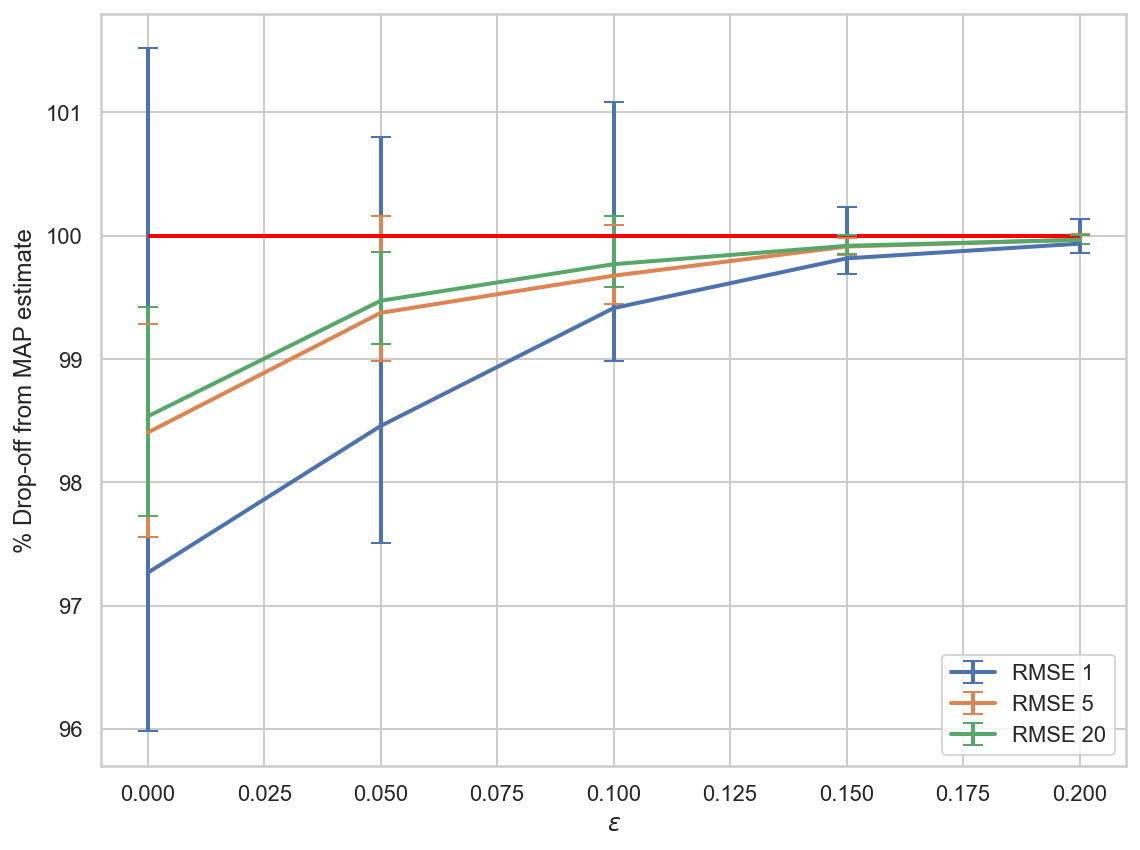

In [18]:
fig, ax = plt.subplots(1, figsize=(8,6))
for x, z in zip(rmse, beamwidths):
    ax.errorbar(epsilons, percentage_dropoff(x, mean_rmse_map)[1], capsize=5, 
                yerr= torch.abs(percentage_dropoff(x, mean_rmse_map) - percentage_dropoff(x, mean_rmse_map)[1])[[0, -1]], label=f'RMSE {z}')
ax.hlines(100, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('% Drop-off from MAP estimate')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/RMSE_MAE/EMP_DIM{dim}_RMSE.jpg", dpi=250, bbox_inches='tight')

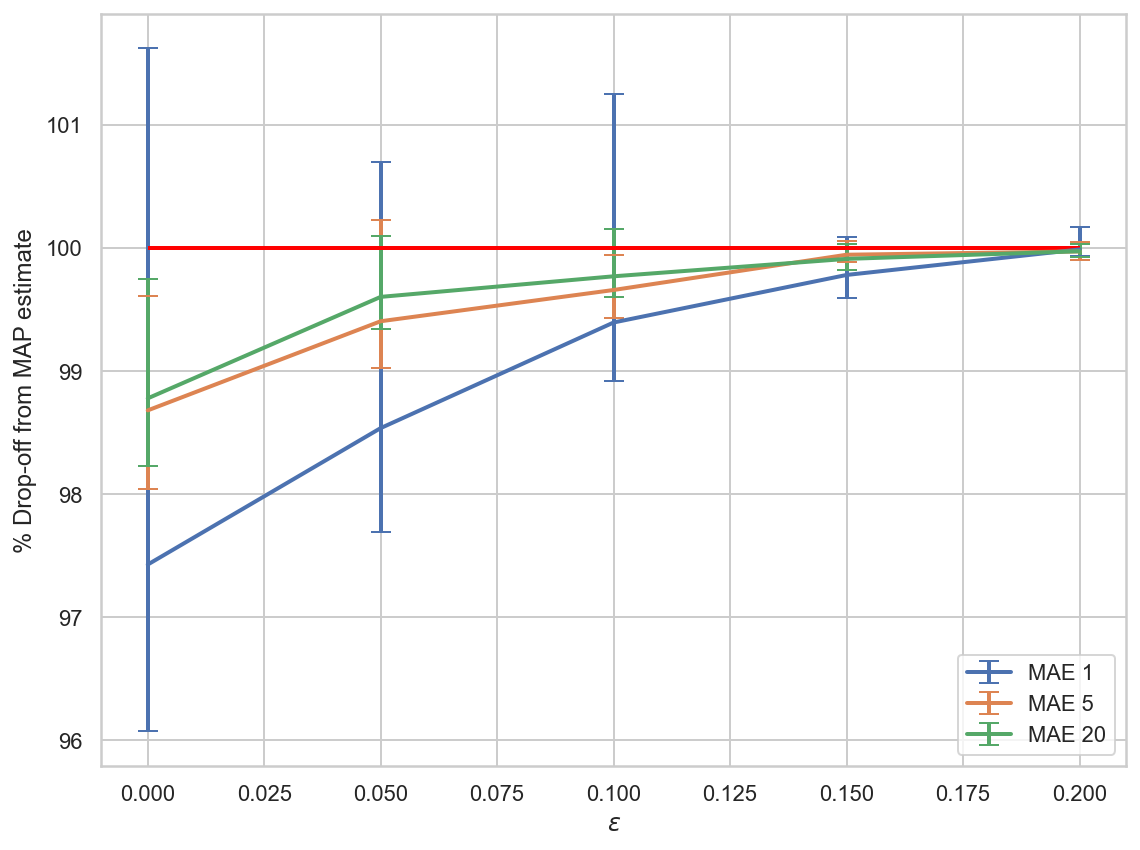

In [19]:
fig, ax = plt.subplots(1, figsize=(8,6))
for y, z in zip(mae, beamwidths):
    ax.errorbar(epsilons, percentage_dropoff(y, mean_mae_map)[1], capsize=5,
                yerr= torch.abs(percentage_dropoff(y, mean_mae_map) - percentage_dropoff(y, mean_mae_map)[1])[[0, -1]], label=f'MAE {z}')
ax.hlines(100, xmin=epsilons[0], xmax=epsilons[-1], color='red')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('% Drop-off from MAP estimate')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/RMSE_MAE/EMP_DIM{dim}_MAE.jpg", dpi=250, bbox_inches='tight')

In [36]:
percentage_dropoff(y, mean_mae_map)[1]

tensor([84.4180, 90.6590, 95.3926, 98.1269, 98.9781])

## Log-likelihood

In [37]:
log_likelihood = []

for i, beam in enumerate(beamwidths):
    log_likelihood.append(torch.quantile(torch.sum(dist.normal.Normal(loc=full_preds[i], scale=signal_std).log_prob(b.regression_targets_test), dim=2), q, dim=1))

In [38]:
map_log_likelihood = torch.sum(dist.normal.Normal(loc=b.empirical_prediction(t.mean), scale=signal_std).log_prob(b.regression_targets_test))

In [39]:
torch.sum(dist.normal.Normal(loc=b.empirical_prediction(b.true_sample), scale=1).log_prob(b.regression_targets_test))

tensor(-3510.7910)

In [40]:
map_log_likelihood

tensor(-3517.5186)

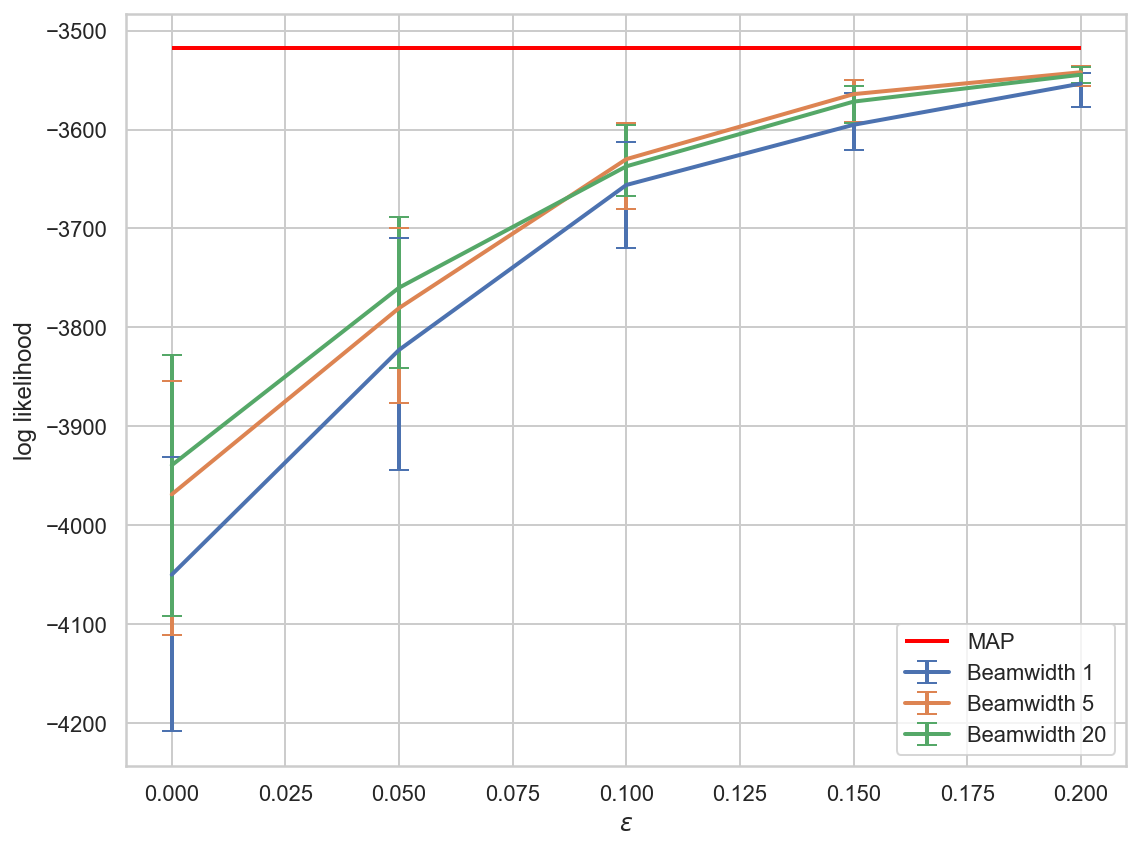

In [41]:
fig, ax = plt.subplots(1, figsize=(8,6))
for x, y in zip(log_likelihood, beamwidths):
    ax.errorbar(epsilons, x[1], capsize=5, 
                yerr = torch.abs(x - x[1])[[0, -1]], label=f'Beamwidth {y}')
ax.hlines(map_log_likelihood, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='MAP')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/MAP_LIKELIHOOD/EMP_DIM{dim}.jpg", dpi=250, bbox_inches='tight')

In [92]:
log_likelihood

[tensor([[-3623.9587, -3607.3848, -3585.2104, -3579.3994, -3569.2041],
         [-3594.3228, -3579.3784, -3570.5742, -3568.3735, -3568.0103],
         [-3572.9976, -3568.9678, -3567.5476, -3567.3625, -3567.0029]]),
 tensor([[-3619.2593, -3598.3708, -3572.2961, -3569.2581, -3567.9287],
         [-3585.1445, -3572.1475, -3568.0386, -3567.4863, -3567.2710],
         [-3570.9883, -3568.5537, -3567.2437, -3566.8496, -3566.7480]]),
 tensor([[-3619.2593, -3593.0581, -3571.6179, -3569.1736, -3567.6997],
         [-3585.1445, -3572.1475, -3567.9419, -3567.4736, -3567.2837],
         [-3569.9976, -3568.2283, -3567.2502, -3566.9485, -3566.9043]])]

# Considering Ensembles

## Log-likelihood

In [68]:
ensemble_preds = []
ensemble_log_likelihood = []
for i, beam in enumerate(beamwidths):
    ensemble_preds.append(torch.mean(full_preds[i], dim=1))
    ensemble_log_likelihood.append(torch.sum(dist.normal.Normal(loc=ensemble_preds[i], scale=signal_std).log_prob(b.regression_targets_test), dim=1))

In [69]:
exact_ensemble = torch.mean(true_preds(b), dim=0)

In [70]:
exact_ensemble_likelihood = torch.sum(dist.normal.Normal(loc=exact_ensemble, scale=signal_std).log_prob(b.regression_targets_test))

In [71]:
full_predictive_mu, full_predictive_var = b.predictive_distribution(b.feature_targets_test)

In [72]:
full_predictive_dist = dist.normal.Normal(loc=full_predictive_mu, scale=torch.pow(full_predictive_var, 0.5))

In [73]:
full_likelihood = torch.sum(full_predictive_dist.log_prob(b.regression_targets_test))

In [74]:
full_likelihood

tensor(-3566.9939)

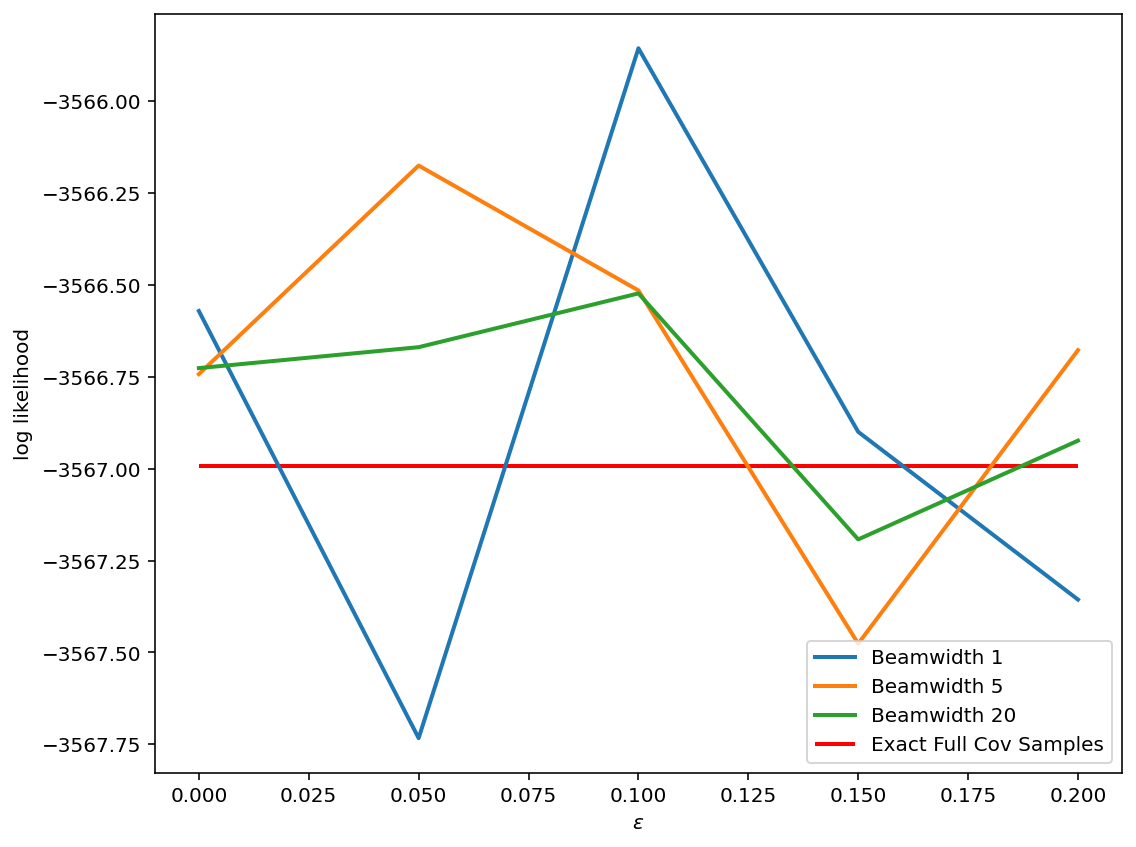

In [75]:
fig, ax = plt.subplots(1, figsize=(8,6))
ax.hlines(exact_ensemble_likelihood, xmin=epsilons[0], xmax=epsilons[-1], color='red', label='Exact Full Cov Samples')
for x, y in zip(ensemble_log_likelihood, beamwidths):
    ax.plot(epsilons, x, label=f'Beamwidth {y}')
ax.set_xlabel(r'$\epsilon$')
ax.set_ylabel('log likelihood')
ax.legend(loc='lower right')
fig.tight_layout()
#fig.savefig(f"Figures/ENSEMBLE_LIKELIHOOD/EMP_DIM{dim}.jpg", dpi=250, bbox_inches='tight')